In [ ]:
!pip install imblearn
!pip install xgboost
!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)

## **Load Dataset**

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **EDA**

* The dataset contains transactions made by credit cards in September 2013 by European cardholders.
* This dataset presents transactions that occurred in two days.
* Where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

* It contains only numerical input variables which are the result of a PCA transformation.
* Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA.
* The only features which have not been transformed with PCA are 'Time' and 'Amount'.
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.
*  Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


## **Preperation**

In [ ]:
X, y = df.iloc[:, :-1], df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # This ensures the class distribution is maintained
    random_state=42
)
print('Shape of the train split : ', X_train.shape)
print('Shape of the testing split : ', X_test.shape)

Shape of the train split :  (227845, 30)
Shape of the testing split :  (56962, 30)


In [ ]:
# Create samples for the class which has less samples (fruad)
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 22745})


In [ ]:
# Undersample the majority class
count_1 = Counter(y_train_resampled).get(1)  # Get count of resampled
rus = RandomUnderSampler(sampling_strategy={0: count_1, 1: count_1}, random_state=42)
X_final, y_final = rus.fit_resample(X_train_resampled, y_train_resampled)

print('Before SMOTE :', Counter(y_train_resampled))
print('After SMOTE :', Counter(y_final))

Before SMOTE : Counter({0: 227451, 1: 22745})
After SMOTE : Counter({0: 22745, 1: 22745})


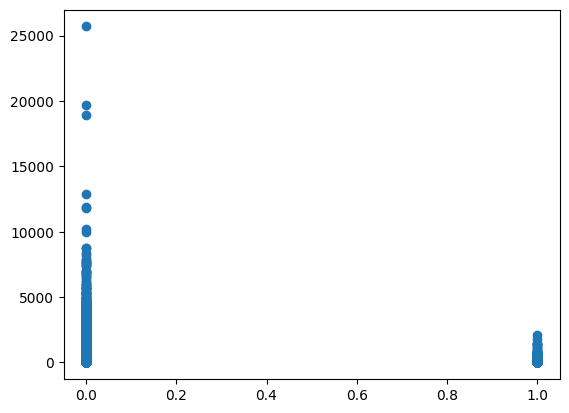

In [8]:
plt.scatter(df['Class'], df['Amount'])

* Frauds deosn't withdraw more than 5000.

## **Model Training**

In [ ]:
X_train_df = X_final
y_train_df = y_final

### **LBGMClassifier**

In [ ]:
# LGBM Classifier
lgb_model = lgb.LGBMClassifier(device='gpu')
lgb_model.fit(X_train_df, y_train_df)

lgb_y_pred = lgb_model.predict(X_test)
lgb_y_scores = lgb_model.predict_proba(X_test)[:, 1]

print('LGBM Classifier:')
print(classification_report(y_test, lgb_y_pred))
print("AUPRC:", average_precision_score(y_test, lgb_y_scores))

[LightGBM] [Info] Number of positive: 22745, number of negative: 22745
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 45490, number of used features: 30
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (1.39 MB) transferred to GPU in 0.003462 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.88      0.58        98

    accuracy                           1.00     56962
   macro avg       0.71      0.94      0.79     56962
weighted avg       1.00      1.00      1.00     5

### **RandomForestClassifier**

In [ ]:
# RandomForest Calssifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_df, y_train_df)

rfc_y_pred = rfc.predict(X_test)
rfc_y_scores = rfc.predict_proba(X_test)[:, 1]

print('Random Forest Classifier:')
print(classification_report(y_test, rfc_y_pred))
print("AUPRC:", average_precision_score(y_test, rfc_y_scores))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.88      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.94      0.83     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.7738020819824695


### **XGBClassifier**

In [ ]:
# XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_df, y_train_df)

y_pred = xgb.predict(X_test)
y_scores = xgb.predict_proba(X_test)[:, 1]

print('XGB Classifier:')
print(classification_report(y_test, y_pred))
print("AUPRC:", average_precision_score(y_test, y_scores))

XGB Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.89      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.94      0.80     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8090257524296575


### **Plot Confusion Matrix**

In [ ]:
# Function to display confusion matrix
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues', values_format='g')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

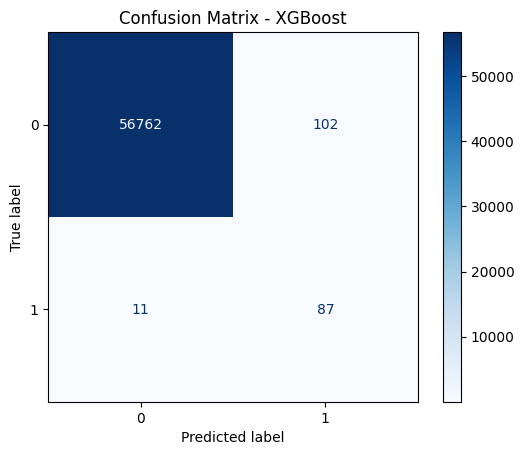

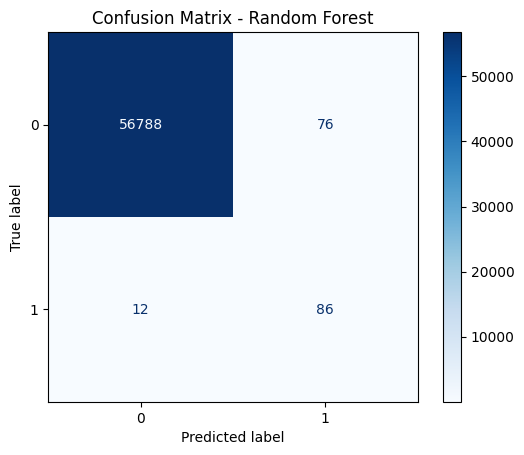

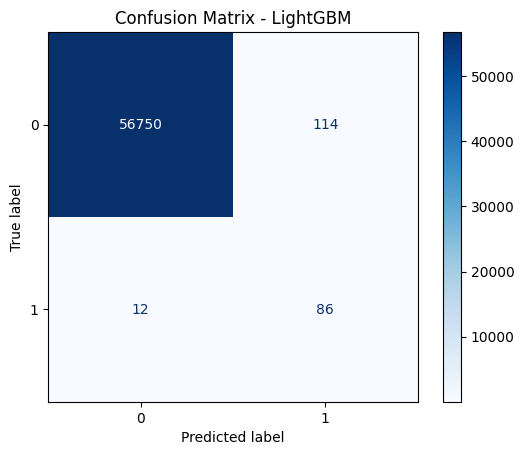

In [ ]:
# XGBoost
plot_confusion(y_test, xgb.predict(X_test), "XGBoost")

# Random Forest
plot_confusion(y_test, rfc.predict(X_test), "Random Forest")

# LightGBM
plot_confusion(y_test, lgb_model.predict(X_test), "LightGBM")

## **Lets Use Scaling**

In [ ]:
# Use StandardScaler to normalize the Time and Amount columns.
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['Time', 'Amount']])
scaled_df = pd.DataFrame(scaled, columns=['Time', 'Amount'])

# Add the Time and Amount columns to the dataset
df_2 = df.drop(columns=['Time', 'Amount'], axis=1)
df_scaled = pd.concat([df_2, scaled_df], axis=1)
df_scaled.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Time,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475


### **Model Training with Scaled Data**

In [ ]:
X, y = df_scaled.drop('Class', axis=1), df_scaled['Class']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=12
)
print('Training dataset shapes :', X_train.shape, y_train.shape, '\n')



# Due to imbalance we are using SMOTE to oversample for class 1
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_resampled_2, y_train_resampled_2 = smote.fit_resample(X_train_2, y_train_2)
# Check the new class distribution
print('Over Sampling using SMOTE.')
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled_2), '\n')



# Now lets undersample the majority class (0)
count_1 = Counter(y_train_resampled_2).get(1)  # Get count of resampled
rus = RandomUnderSampler(sampling_strategy={0: count_1, 1: count_1}, random_state=42)
X_final_2, y_final_2 = rus.fit_resample(X_train_resampled_2, y_train_resampled_2)
print('Under Sampling using RandomUnderSampler.')
print('Before RUS :', Counter(y_train_resampled_2))
print('After RUS :', Counter(y_final_2), '\n')


print(f'Final training dataset shape : {X_final_2.shape}, {y_final_2.shape}')
print(f'Class distribution : {Counter(y_final_2)}')
# Final datasets -- (X_final_2, y_final_2)

Training dataset shapes : (227845, 30) (227845,) 

Over Sampling using SMOTE.
Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227446, 1: 22744}) 

Under Sampling using RandomUnderSampler.
Before RUS : Counter({0: 227446, 1: 22744})
After RUS : Counter({0: 22744, 1: 22744}) 

Final training dataset shape : (45488, 30), (45488,)
Class distribution : Counter({0: 22744, 1: 22744})


In [ ]:
# Testing Dataset
print(f'Testing datset shape : {X_test_2.shape}, {y_test.shape}')
print(f'Class distribution of y_test_2 : {Counter(y_test_2)}\n')

# Now lets undersample the majority class (0)
count_1 = Counter(y_test_2).get(1)  # Get count of resampled
rus = RandomUnderSampler(sampling_strategy={0: count_1 * 4, 1: count_1}, random_state=42)
X_test_final, y_test_final = rus.fit_resample(X_test_2, y_test_2)
print('Under Sampling using RandomUnderSampler.')
print('Before RUS :', Counter(y_test_2))
print('After RUS :', Counter(y_test_final), '\n')

# Final Dataset --- X_test_final, y_test_final

Testing datset shape : (56962, 30), (56962,)
Class distribution of y_test_2 : Counter({0: 56869, 1: 93})

Under Sampling using RandomUnderSampler.
Before RUS : Counter({0: 56869, 1: 93})
After RUS : Counter({0: 372, 1: 93}) 



### **XGBoost**

In [ ]:
# Using GridSearchCV to find best parameters
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}


grid = GridSearchCV(
    XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
        ),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error'
    )

grid.fit(X_final_2, y_final_2)
print('best parameters :', grid.best_params_)

best parameters : {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3}


In [ ]:
xgb_model_tuned = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.2,
    max_depth=7,
    min_child_weight=3
)
xgb_model_tuned.fit(X_final_2, y_final_2)

# Evaluation
y_pred = xgb_model_tuned.predict(X_test_final)
y_scores = xgb_model_tuned.predict_proba(X_test_final)[:, 1]

print('XGB Classifier:')
print(classification_report(y_test_final, y_pred))
print("AUPRC:", average_precision_score(y_test_final, y_scores))

XGB Classifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       372
           1       1.00      0.90      0.95        93

    accuracy                           0.98       465
   macro avg       0.99      0.95      0.97       465
weighted avg       0.98      0.98      0.98       465

AUPRC: 0.9689236126780624


* **Precision** for class 1 = 1.00 → Every predicted class 1 is actually correct (no false positives)
* **Recall** for class 1 = 0.77 → It still misses 23% of the actual class 1 samples

* **F1-score** for class 1 = 0.87 → Good balance overall

* **AUPRC** = 0.96 → This is excellent and indicates high confidence across thresholds